# Saq aquifer linear depletion trend figure

This notebook reproduces the Saq aquifer linear depletion trend figure.

## Data source 

The file `CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc` included as part of this binder was downloaded directly from the University of Texas Center for Space Research (CSR) website, specifically by using [this direct link](http://download.csr.utexas.edu/outgoing/grace/RL06_mascons/CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc). For general information on this dataset, please [visit the official site here](https://www2.csr.utexas.edu/grace/RL06_mascons.html). Acknowledgement/citation should be made to the following reference as well as others mentioned in the link above. 

Save, H., S. Bettadpur, and B.D. Tapley (2016), High resolution CSR GRACE RL05 mascons, J. Geophys. Res. Solid Earth, 121, doi:[10.1002/2016JB013007](http://dx.doi.org/10.1002/2016JB013007).

## Region of study

The file `Saq.geojson` is included as an example region of study to calculate depletion trends. Optionally use a different shape by loading it directly as a geojson dictionary and then converting it into a geopandas dataframe. 

In [1]:
import os
if 'PROJ_LIB' in os.environ:
    del os.environ['PROJ_LIB'] # Fix for conflicting pyproj in base environment vs our env
import geopandas as gpd 
shp = gpd.read_file("Saq.geojson") # Example region of study included in binder as a geojson file. 
# Optionally replace the shape by pasting a geojson dictionary here:
example_shp_as_json_dict = \
{
    "type":"FeatureCollection",
    "features":[
        {"geometry":
         {"coordinates":[[
             [35.375, 24.434366],
             [35.375, 32.124512],
             [45.835997, 32.124512],
             [45.835997, 24.434366],
             [35.375, 24.434366]
         ]],
          "type":"Polygon"},
         "properties":{},
         "type":"Feature"}]
}
# Uncomment this line to replace shp with the above geojson dict:
#shp = gpd.GeoDataFrame.from_features(example_shp_as_json_dict, crs="epsg:4326")

shp.explore(tiles="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}", attr="Google basemap")

## Load and process the GRACE data

The next cell loads the GRACE data from the netCDF\* into an [xarray.DataSet](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), and then proceeds to the following steps:

1. Clip the data to the region of interest. 
2. Reduce the data to a time series (spatial average at each time step). 

\*If the netcdf doesn't exist, it will download it. You can always update it to the latest available data using the `.update_data()` method, but it will take about 2 minutes to download it!

In [2]:
import grace_mascon
csr_file="CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc"
data = grace_mascon.trend(csr_file, shp)

The data is stored in `data.xr` (global GRACE data from the netCDF file), `data.xrc` (data clipped to the shape), and `data.ts` (time series) . The following cell displays an HTML representation of `data.xrc`:

In [3]:
data.xrc

<xarray.Dataset>
Dimensions:        (time: 212, x: 41, y: 30)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-18 ... 2022-08-16T12:00:00
  * x              (x) float32 35.62 35.88 36.12 36.38 ... 45.12 45.38 45.62
  * y              (y) float32 24.62 24.88 25.12 25.38 ... 31.38 31.62 31.88
Data variables:
    lwe_thickness  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL06_Mascons_all-co...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL06Mv2
    subtitle:                   GRACE/GRACE-FO Total water storage with all c...
    ...                         ...
    user_note_2:                The accelerometer on the GRACE-FO 2 spacecraf...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    date_created:               2022-10-11T11:36:56Z
    variable:                   liquid water equivalent thickness
    label:                      RL06rc24cE
    Mask:                       Global

## Time series visualization

Finally, the following cell displays an ipywidget where you can select a period and display a figure of the time series. The period selected will determine the trend (in mm/year) displayed in the figure. 

In [14]:
data.display_ts()

interactive(children=(DatePicker(value=Timestamp('2007-01-01 00:00:00', freq='D'), description='Start'), DateP…

You can also access the current state of the figure with `data.fig`,

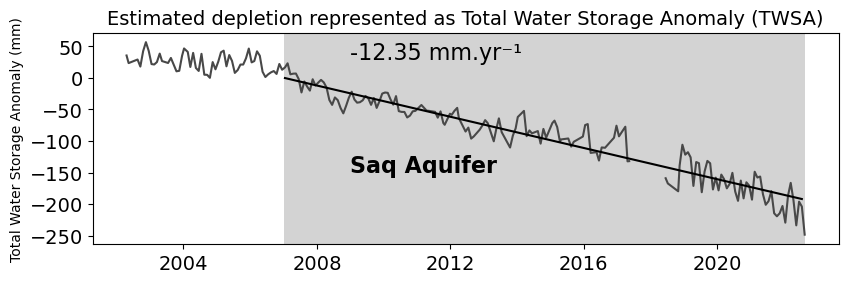

In [11]:
data.fig

or use the methods `.to_png` or `.to_svg` to save it:

In [6]:
data.to_svg("test.svg", dpi=600, bbox_inches='tight', transparent = True)

In [7]:
data.to_png("test.png", dpi=600, bbox_inches='tight', transparent = True)